In [2]:
import os
import json
import torch

from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
from ultralytics import YOLO
from PIL import Image
from tqdm import tqdm

print('Setting up models...')
device = 'cuda'

detection_model_path='weights/icon_detect/model.pt' # YOLO
som_model = get_yolo_model(detection_model_path)
som_model.to(device)

print('model to {}'.format(device))

Setting up models...
model to cuda


In [4]:
# Load caption model
caption_model_processor = get_caption_model_processor(
    model_name='florence2',
    model_name_or_path="weights/icon_caption_florence",
    device=device
)
print(f'Models loaded successfully on {device}')

Models loaded successfully on cuda


In [5]:
# Set up and check input/output directories exist
INPUT_FRAMES_DIR = 'input_frames'
OUTPUT_IMAGE_DIR = 'outputs/images'
OUTPUT_JSON_DIR = 'outputs/json'

os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_JSON_DIR, exist_ok=True)

In [6]:
# Model inference settings
BOX_TRESHOLD = 0.05
draw_bbox_config = {
    'text_scale': 0.8,
    'text_thickness': 1,
    'text_padding': 1,
    'thickness': 1,
}

In [ ]:
print("Starting batch processing...")

image_files = [f for f in os.listdir(INPUT_FRAMES_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for filename in tqdm(image_files, desc="Processing Frames"):
    try:
        base_filename = os.path.splitext(filename)[0]
        input_image_path = os.path.join(INPUT_FRAMES_DIR, filename)

        output_image_path = os.path.join(OUTPUT_IMAGE_DIR, f"{base_filename}_annotated.png")
        output_json_path = os.path.join(OUTPUT_JSON_DIR, f"{base_filename}_data.json")

        if os.path.exists(output_json_path):
            continue

        ocr_bbox_rslt, _ = check_ocr_box(
            input_image_path,
            display_img=False,
            output_bb_format='xyxy',
            use_paddleocr=True,
        )
        text, ocr_bbox = ocr_bbox_rslt

        annotated_image, label_coordinates, parsed_content_list = get_som_labeled_img(
            input_image_path,
            som_model,
            BOX_TRESHOLD=BOX_TRESHOLD,
            output_coord_in_ratio=True,
            ocr_bbox=ocr_bbox,
            draw_bbox_config=draw_bbox_config,
            caption_model_processor=caption_model_processor,
            ocr_text=text,
            use_local_semantics=True,
            iou_threshold=0.7,
            scale_img=False,
            batch_size=128,
        )

        annotated_image.save(output_image_path)

        with open(output_json_path, 'w') as f:
            json.dump(parsed_content_list, f, indent=4)

    except Exception as e:
        print(f"Failed to process {filename}. Error: {e}")
        continue

print('Batch processing complete!')

## Do not run below this line!
Old code below, only for reference.

Refer to 'demo.ipynb' for full original script.

In [3]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
# import util.utils
# importlib.reload(utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



In [3]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [ ]:
# reload utils
import importlib
import utils
importlib.reload(utils)
# from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

# image_path = 'imgs/google_page.png'
# image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
# image_path = 'imgs/word.png'
# image_path = 'imgs/excel2.png'
# image_path = '/home/oberon/projects/OmniParser/imgs/frame_022500_game_1.jpg'
# image_path = '/home/oberon/projects/OmniParser/imgs/frame_023100_game_1.jpg'
# image_path = 'imgs/frame_025200_game_1.jpg'
image_path = 'imgs/frame_027300_game_1.jpg'

# Open images directory

# Loop through all files and load file path into array

# For loop which iterates through the entire length of the array of images

# Access first element in array and assign to variable

# Set image variable as the temp array element variable

# Continue with usual processing

# Output of image and json file into local directory, providing a file name and increasing number value as a suffix

# Repeat loop

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (1920, 1080)

0: 736x1280 119 icons, 22.4ms
Speed: 26.2ms preprocess, 22.4ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


len(filtered_boxes): 128 54
time to get parsed content: 0.18864750862121582


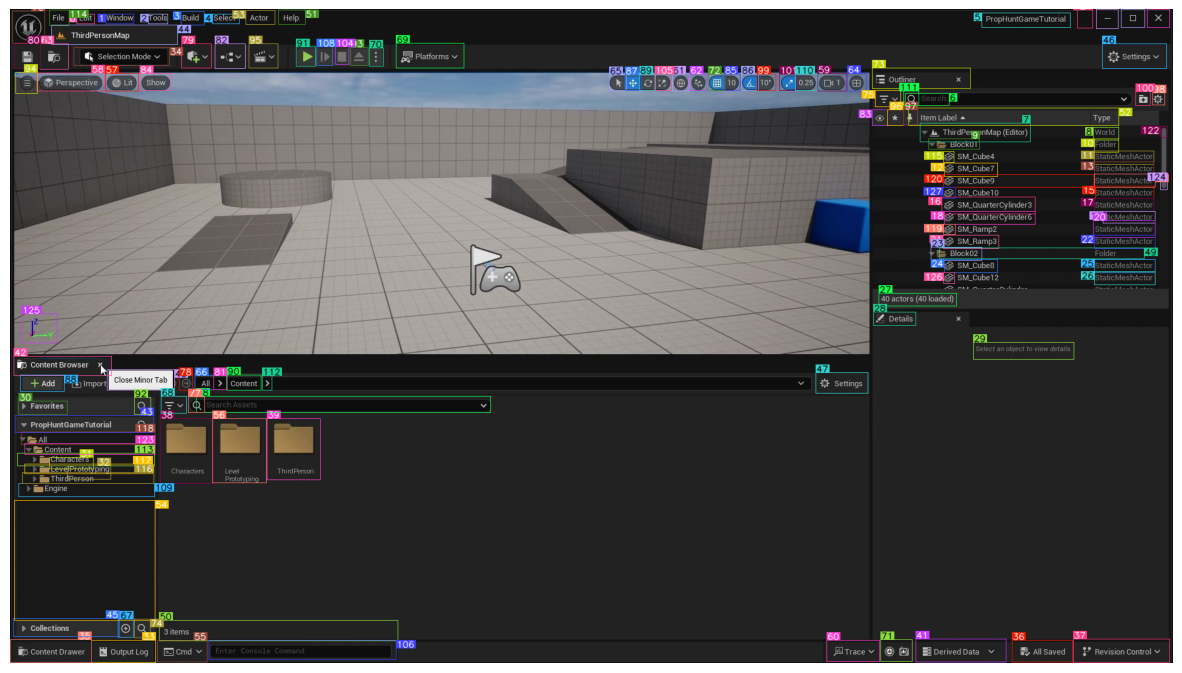

In [26]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [27]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,ID
0,text,"[0.0572916679084301, 0.007407407276332378, 0.0...",False,Edit,box_ocr_content_ocr,0
1,text,"[0.08229167014360428, 0.007407407276332378, 0....",False,Window,box_ocr_content_ocr,1
2,text,"[0.11874999850988388, 0.007407407276332378, 0....",False,Tools,box_ocr_content_ocr,2
3,text,"[0.14687499403953552, 0.003703703638166189, 0....",False,Build,box_ocr_content_ocr,3
4,text,"[0.17395833134651184, 0.007407407276332378, 0....",False,Select,box_ocr_content_ocr,4
...,...,...,...,...,...,...
123,icon,"[0.012651252560317516, 0.6640593409538269, 0.1...",True,Focalist,box_yolo_content_yolo,123
124,icon,"[0.9892986416816711, 0.2620523273944855, 0.994...",True,Unanswerable,box_yolo_content_yolo,124
125,icon,"[0.010228174738585949, 0.4658771753311157, 0.0...",True,Increase,box_yolo_content_yolo,125
126,icon,"[0.8027151226997375, 0.4034262001514435, 0.812...",True,A box or container for storage.,box_yolo_content_yolo,126


In [28]:
parsed_content_list

[{'type': 'text',
  'bbox': [0.0572916679084301,
   0.007407407276332378,
   0.0729166641831398,
   0.02222222276031971],
  'interactivity': False,
  'content': 'Edit',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.08229167014360428,
   0.007407407276332378,
   0.10625000298023224,
   0.02222222276031971],
  'interactivity': False,
  'content': 'Window',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.11874999850988388,
   0.007407407276332378,
   0.1354166716337204,
   0.02222222276031971],
  'interactivity': False,
  'content': 'Tools',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.14687499403953552,
   0.003703703638166189,
   0.1666666716337204,
   0.024074073880910873],
  'interactivity': False,
  'content': 'Build',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.17395833134651184,
   0.007407407276332378,
   0.19687500596046448,
   0.02222222276031971],
  'interactivity': False,
  'content': 'Select'

In [29]:
df.to_csv('UE5_menu_viewport_2.csv', index=False)